In [2]:
import json
import os
import re
import requests
import wget
from tqdm import tqdm
import time
from collections import defaultdict
from datasets import Dataset
import matplotlib.pyplot as plt
from setretrieval.utils.utils import pickdump, pickload
import random
import copy
from datasets import DatasetDict

/accounts/projects/sewonm/prasann/.conda/envs/scaling2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
fields = [
    "Computer Science",
    "Biology",
    "Medicine",
    "Physics",
    "History",
    "Art",
    "Linguistics",
    "Philosophy",
    "Business",
    "Psychology"
]

# keep on going until there are at least minpapers with mincites
def calibrate_field(field, mincites=400, minpapers=100):
    endyear = ":2025"
    startyear = 2023
    while startyear > 2000:
        result = recent_field_papers(field, mincites=mincites, year=f"{startyear}{endyear}")
        try:
            if len(result['data']) >= minpapers:
                break
        except KeyError:
            print(result)
        startyear -= 1
    result['startyear'] = startyear
    return result

def recent_field_papers(field, mincites=400, year="2023:2025"):
    # get a list of recent papers from field with at least mincites citations
    url = "https://api.semanticscholar.org/graph/v1/paper/search/bulk"
    params = {
        'query': "find",
        'fieldsOfStudy': field,
        'minCitationCount': mincites, 
        'publicationDateOrYear': year,
        'limit': 50,
        'fields': "title,authors,year,externalIds,citationCount,referenceCount,fieldsOfStudy"
    }
    headers = {
        'Content-Type': 'application/json'
    }
    time.sleep(1)
    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    return data

In [ ]:
fielddata = []
for field in fields:
    fieldresult = calibrate_field(field, mincites=400, minpapers=100)
    print(f"Calibrating field {field}")
    fielddata.append(fieldresult)
with open("starterpapers.json", "w") as f:
    json.dump(fielddata, f, indent=4)

In [3]:
fielddata = json.load(open("starterpapers.json"))

In [14]:
fielddata[0]['data'][8]

{'paperId': '0e0e706e13f160e74cac9556f28ab9a358c148d2',
 'externalIds': {'DBLP': 'journals/corr/abs-2310-03693',
  'ArXiv': '2310.03693',
  'DOI': '10.48550/arXiv.2310.03693',
  'CorpusId': 263671523},
 'title': 'Fine-tuning Aligned Language Models Compromises Safety, Even When Users Do Not Intend To!',
 'year': 2023,
 'referenceCount': 92,
 'citationCount': 874,
 'fieldsOfStudy': ['Computer Science'],
 'authors': [{'authorId': '2111683101', 'name': 'Xiangyu Qi'},
  {'authorId': '2273035656', 'name': 'Yi Zeng'},
  {'authorId': '2144071564', 'name': 'Tinghao Xie'},
  {'authorId': '2239530969', 'name': 'Pin-Yu Chen'},
  {'authorId': '2254249161', 'name': 'Ruoxi Jia'},
  {'authorId': '2254282852', 'name': 'Prateek Mittal'},
  {'authorId': '2254262712', 'name': 'Peter Henderson'}]}

In [3]:
citationdata = []
domaininfo = []
basepath = "../propercache/data/citationdata"
for data in os.listdir(basepath):
    if "loopdata" in data:
        ndata = json.load(open(os.path.join(basepath, data)))   
        citationdata.extend(ndata)
        domaininfo.extend([os.path.join(basepath, data)] * len(ndata))

In [4]:
allpapers = []
alldomains = []
pset = set()
for i, c in tqdm(enumerate(citationdata)): 
    def addpaper(cdict):
        if cdict['paperId'] not in pset and 'abstract' in cdict and cdict['abstract'] is not None:
            pset.add(cdict['paperId'])
            atext = cdict['abstract'].replace('\n', '')
            allpapers.append(f"Title: {cdict['title']} Abstract: {atext}")
            alldomains.append(domaininfo[i])
    addpaper(c)
    for r in c['references']:
        addpaper(r)

16588it [00:00, 25602.31it/s]


In [5]:
queryprompt = "Given the following title / abstract, find other title / abstracts that are related in some way: {}"
def abstract_to_embeddtraindata(fulldata, apapers, testsplit=0.9):
    newdata = []
    newfullinds = list(range(len(fulldata)))
    random.shuffle(newfullinds)
    for cind in tqdm(newfullinds):
        c = fulldata[cind]
        refcnt = 0
        for r in c['references']:
            if 'abstract' in c and c['abstract'] is not None:
                newdata.append({
                    'query': queryprompt.format(f"Title: {c['title']} Abstract: {c['abstract']}"),
                    'positive': f"Title: {r['title']} Abstract: {r['abstract']}",
                    'negative': random.choice(apapers),
                    'domain': alldomains[cind]
                })
                refcnt += 1
            if refcnt >=3: # max 3 per thing
                break
    return DatasetDict({
        'train': Dataset.from_list(newdata[:int(len(newdata) * testsplit)]),
        'test': Dataset.from_list(newdata[int(len(newdata) * testsplit):])
    })

absreldata = abstract_to_embeddtraindata(citationdata, allpapers)

100%|██████████| 16588/16588 [00:00<00:00, 88893.32it/s]


In [6]:
absreldata

DatasetDict({
    train: Dataset({
        features: ['query', 'positive', 'negative', 'domain'],
        num_rows: 41238
    })
    test: Dataset({
        features: ['query', 'positive', 'negative', 'domain'],
        num_rows: 4582
    })
})

In [6]:
from datasets import concatenate_datasets

In [7]:
abstest = concatenate_datasets([Dataset.load_from_disk("../propercache/data/evalsets/bioabs_newpipetest/"), Dataset.load_from_disk("../propercache/data/evalsets/physabs_newpipetest/")])

In [ ]:
allposchunks = [[r['text'] for r in pc] for pc in abstest['pos_chunks']]
apflatset = set([item for sublist in allposchunks for item in sublist])
absreldata['train'] = absreldata['train'].filter(lambda x: x['positive'] not in apflatset)
absreldata['train'] = absreldata['train'].filter(lambda x: x['domain'] != '../propercache/data/citationdata/loopdata_1.json')

In [11]:
absreldata['train'] = absreldata['train'].shuffle(seed=42).select(range(27000))

In [ ]:
absreldata.save_to_disk("../propercache/data/colbert_training/abstract_relevant_train_30k_newfilt")

Saving the dataset (1/1 shards): 100%|██████████| 4582/4582 [00:00<00:00, 29168.93 examples/s]


In [ ]:
absreldata[0]

In [34]:
rdset = Dataset.from_dict({"text": allpapers, "domain": alldomains})

In [42]:
rdset[40000]

{'text': 'Title: SIRT1 Regulates Dendritic Development in Hippocampal Neurons Abstract: Dendritic arborization is required for proper neuronal connectivity. SIRT1, a NAD+ dependent histone deacetylase, has been associated to ageing and longevity, which in neurons is linked to neuronal differentiation and neuroprotection. In the present study, the role of SIRT1 in dendritic development was evaluated in cultured hippocampal neurons which were transfected at 3 days in vitro with a construct coding for SIRT1 or for the dominant negative SIRT1H363Y, which lacks the catalytic activity. Neurons overexpressing SIRT1 showed an increased dendritic arborization, while neurons overexpressing SIRT1H363Y showed a reduction in dendritic arbor complexity. The effect of SIRT1 was mimicked by treatment with resveratrol, a well known activator of SIRT1, which has no effect in neurons overexpressing SIRT1H363Y indicating that the effect of resveratrol was specifically mediated by SIRT1. Moreover, hippocam

In [44]:
rdset.shuffle(seed=42).save_to_disk("../propercache/data/datastores/fullabstractset")
rdset.shuffle(seed=42).select(range(10000)).save_to_disk("../propercache/data/datastores/fullabstractset10k_heldout")

Saving the dataset (0/1 shards):   0%|          | 0/156387 [00:00<?, ? examples/s]

Saving the dataset (1/1 shards): 100%|██████████| 10000/10000 [00:00<00:00, 70287.55 examples/s]


In [45]:
rdset =  Dataset.load_from_disk("../propercache/data/datastores/fullabstractset")

In [57]:
print(rdset[30]['text'])

Title: Connecting Vision and Language with Localized Narratives Abstract: We propose Localized Narratives, a new form of multimodal image annotations connecting vision and language. We ask annotators to describe an image with their voice while simultaneously hovering their mouse over the region they are describing. Since the voice and the mouse pointer are synchronized, we can localize every single word in the description. This dense visual grounding takes the form of a mouse trace segment per word and is unique to our data. We annotated 849k images with Localized Narratives: the whole COCO, Flickr30k, and ADE20K datasets, and 671k images of Open Images, all of which we make publicly available. We provide an extensive analysis of these annotations showing they are diverse, accurate, and efficient to produce. We also demonstrate their utility on the application of controlled image captioning.


In [7]:
gutenbergdata = Dataset.load_from_disk("../propercache/data/gutenberg_1k")

In [ ]:
def process_gutenberg_chunks(intext, idval=None):
    divided = intext.split("\n\n")
    results = []
    for d in divided:
        if len(d) < 100:
            continue
        if len(d) > 2000:
            # split by sentences
            restmp = d.replace("\n", " ").split('.')
            # join every 5 sentences
            restmp = [restmp[i:i+10] for i in range(0, len(restmp), 5)]
            results.extend([". ".join(r).strip()[:2000] for r in restmp])
        else:
            results.append(d.replace("\n", " ").strip())
    return [{'text': r, 'wc': len(r.split()), 'id': idval} for r in results]


def group_chunks_maxsize(clist, msize=200):
    # group chunks into group of at least msize
    newclist = []
    cur = {'text': '', 'id': '', 'wc': 0}
    for c in clist: 
        if cur['wc'] + c['wc'] <= msize: 
            cur['text'] += c['text']
            cur['wc'] += c['wc']
            cur['id'] = c['id']
        else: 
            newclist.append(cur)
            cur = c
    newclist.append(cur)
    return newclist

In [ ]:
allbooks = []
for i, b in enumerate(gutenbergdata):
    allbooks.append(process_gutenberg_chunks(b['text'], idval=i))

In [9]:
gchunks = []
for b in tqdm(allbooks):
    gchunks.append(group_chunks_maxsize(b, msize=300))

100%|██████████| 1000/1000 [00:00<00:00, 2531.43it/s]


In [14]:
len(allbooks)
# flatten allbooks (which is a list of lists)
flatbooks = [item for sublist in gchunks for item in sublist]

In [15]:
pickdump(gchunks, "../propercache/data/gutenberg_chunked_dump")

In [18]:
gchunks = pickload("../propercache/data/gutenberg_chunked_dump")

In [ ]:
# get gutenberg proximity training data
gutenberg_prox_query = "Given the following book passage, find passages which are likely to be in the neighboring 20 passages:\n\n {}"
def create_gutenberg_prox_data(bookchunks, perbook=50, testsplit=0.9):
    # bookchunks is a list of list of chunks in the book, randomly select 40 anchors, and for these 40 anchors, randomly select
    # one chunk within a random 10 chunk window. Get a negative which is outside of this window.
    # repeat this per book.
    newdata = []
    totskipped = 0
    for i, b in tqdm(enumerate(bookchunks)):
        # get random index from len of b
        if len(b) < perbook:
            # print("Skip {i}")
            totskipped += 1
            continue
        anchorinds = random.sample(range(len(b)), perbook)
        for aind in anchorinds:
            # get a random chunk within 10 chunks of a
            window = 10
            start = max(0, aind - window)
            end = min(len(b), aind + window)
            poschunks = [r['text'] for r in b[start:end]]
            # print(len(poschunks))
            while True:
                negchunk = random.choice(b)            
                if negchunk['text'] not in poschunks:
                    break
            while True:
                poschunk = random.choice(poschunks)
                if poschunk != b[aind]['text']:
                    break
            newdata.append({
                'query': gutenberg_prox_query.format(b[aind]['text']),
                'positive': poschunk,
                'negative': negchunk['text'], 
                'bookid': i,
                'chunkid': aind
            })
    print(f"Skipped {totskipped} books")
    return DatasetDict({
        'train': Dataset.from_list(newdata[:int(len(newdata) * testsplit)]),
        'test': Dataset.from_list(newdata[int(len(newdata) * testsplit):])
    })

gutenberg_prox_data = create_gutenberg_prox_data(gchunks[:800], 50, 0.9)
# gutenberg_prox_data.save_to_disk("../propercache/data/datastores/gutenberg_prox_train_40k")

800it [00:00, 5525.74it/s]


Skipped 76 books


In [46]:
abspath = "../propercache/data/colbert_training/abstract_relevant_train_40k"
gutproxpath = "../propercache/data/colbert_training/gutenberg_prox_train_40k"
absddict = DatasetDict.load_from_disk(abspath)
gutproxd = DatasetDict.load_from_disk(gutproxpath)
# filter to only ones where query, positive, negative are strings
ndict = absddict.filter(lambda x: isinstance(x['query'], str) and isinstance(x['positive'], str) and isinstance(x['negative'], str))
gutproxd = gutproxd.filter(lambda x: isinstance(x['query'], str) and isinstance(x['positive'], str) and isinstance(x['negative'], str))

In [50]:
data1 = pickload("/accounts/projects/sewonm/prasann/projects/prasannfirstphd/longsynth/cache/setgold_pipeline/stage1.pkl")
data2 = pickload("/accounts/projects/sewonm/prasann/projects/prasannfirstphd/longsynth/cache/setgold_pipeline/stage2.pkl")
data3 = pickload("/accounts/projects/sewonm/prasann/projects/prasannfirstphd/longsynth/cache/setgold_pipeline/stage3.pkl")
data4 = pickload("/accounts/projects/sewonm/prasann/projects/prasannfirstphd/longsynth/cache/setgold_pipeline/stage4.pkl")

In [53]:
len(data1[0]['valids'])

10000

In [55]:
from statistics import mean

In [56]:
mean([sum(d['valids']) for d in data1])

197.1586345381526

In [57]:
mean([sum(d['valids']) for d in data2])

86.36546184738955

In [62]:
mean([len(d['final_gold_chunks']) for d in data4])

25.76004016064257

In [60]:
data4

[{'question_idx': 0,
  'gpt5_valids': [True, True, True, False, False, True, False],
  'gemini_valids': [True, False, False, False, False, False, False],
  'gpt5_positive_indices': [1341, 3471, 4464, 7438],
  'gemini_positive_indices': [1341],
  'final_gold_chunks': [1341],
  'gpt5_num_positives': 4,
  'gemini_num_positives': 1},
 {'question_idx': 1,
  'gpt5_valids': [],
  'gemini_valids': [],
  'gpt5_positive_indices': [],
  'gemini_positive_indices': [],
  'final_gold_chunks': [],
  'gpt5_num_positives': 0,
  'gemini_num_positives': 0},
 {'question_idx': 2,
  'gpt5_valids': [True, True, False, False, True, True, True],
  'gemini_valids': [True, True, False, False, False, True, True],
  'gpt5_positive_indices': [1354, 1360, 4375, 5388, 7755],
  'gemini_positive_indices': [1354, 1360, 5388, 7755],
  'final_gold_chunks': [1354, 1360, 5388, 7755],
  'gpt5_num_positives': 5,
  'gemini_num_positives': 4},
 {'question_idx': 3,
  'gpt5_valids': [True, True, True, False, False, True, False],


In [47]:
ndict.save_to_disk(abspath+"_filtered")
gutproxd.save_to_disk(gutproxpath+"_filtered")


Saving the dataset (1/1 shards): 100%|██████████| 3620/3620 [00:00<00:00, 23660.41 examples/s]


In [16]:
bookdump = Dataset.from_list(flatbooks)
bookdump.save_to_disk("../propercache/data/gutenberg_chunks_800k")

Saving the dataset (1/1 shards): 100%|██████████| 299582/299582 [00:03<00:00, 81098.45 examples/s]  


In [3]:
bd = Dataset.load_from_disk("../propercache/data/gutenberg_chunks_800k")

In [59]:
trainchunks = bd.filter(lambda x: x['id'] < 800)
testchunks = bd.filter(lambda x: x['id'] >= 800)

Filter: 100%|██████████| 299582/299582 [00:00<00:00, 395478.61 examples/s]


In [ ]:
trainchunks.save_to_disk("../propercache/data/datastores/gutenberg_train_240k")
testchunks.save_to_disk("../propercache/data/datastores/gutenberg_test_60k")

Saving the dataset (1/1 shards): 100%|██████████| 66001/66001 [00:00<00:00, 71335.56 examples/s]


In [ ]:
trainchunks.shuffle(seed=42).save_to_disk("../propercache/data/datastores/gutenberg_train_240k_shuffled")

Saving the dataset (1/1 shards): 100%|██████████| 233581/233581 [00:03<00:00, 72153.79 examples/s]


In [ ]:
bd[200000]['text']

'But never a word had Mr. Paul said about raising Tom\'s salary. Tom supposed he did not intend to raise it. And, much as he liked his post, and, for many reasons, his stay at Islip, he entertained notions of quitting both. Valentine had stopped the income his father had paid to Mrs. Chandler; and Tom\'s two hundred a-year, combined with the trifle remaining to her out of her private income, only just sufficed to keep the home going.It chanced that on the very same Sunday evening, when they were talking at North Villa of Valentine\'s doings, Tom broached the subject to his mother. They were sitting out of doors in the warm summer twilight, sniffing the haycocks in the neighbouring field. Tom spoke abruptly."I am thinking of it. You see, mother mine, there is no prospect of advancement where I am. It seems to me that I may jog on for ever at two hundred a-year----""As things are, yes: but nothing more. If--for instance--if I wanted to set up a home of my own, I have no means of doing it

(array([1.250e+02, 7.700e+02, 2.638e+03, 4.872e+03, 1.558e+03, 1.400e+01,
        6.000e+00, 7.000e+00, 3.000e+00, 7.000e+00]),
 array([ 116. ,  531.9,  947.8, 1363.7, 1779.6, 2195.5, 2611.4, 3027.3,
        3443.2, 3859.1, 4275. ]),
 <BarContainer object of 10 artists>)

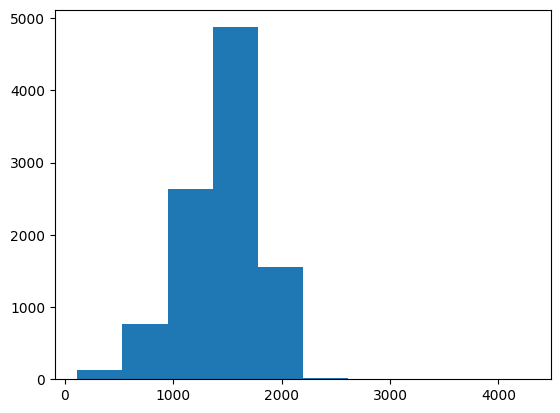

In [4]:
plt.hist([len(b['text']) for b in bd.select(range(10000))])

(array([252371., 240543., 123190.,  73659.,  49004.,  36096.,  25963.,
         19852.,  14021.,  19830.]),
 array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.,
        1800., 2000.]),
 <BarContainer object of 10 artists>)

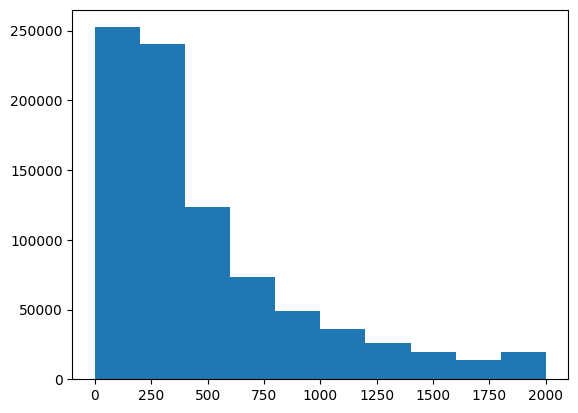

In [47]:
plt.hist([len(b['text']) for b in flatbooks])

In [ ]:
len(all)

In [28]:
chunks[102]

' Sugar was grown there in the semi-marshy tracts near the river.  Gold was to be found there in considerable quantities, and there were several pearl fisheries upon the coasts.  The district was more populous than any part of Spanish America, for it was not only healthier, but more open, affording little cover for Maroons. '

(array([146.,  53.,  31., 111., 255., 246.,  93.,  27.,   7.,   2.]),
 array([   0. ,  370.5,  741. , 1111.5, 1482. , 1852.5, 2223. , 2593.5,
        2964. , 3334.5, 3705. ]),
 <BarContainer object of 10 artists>)

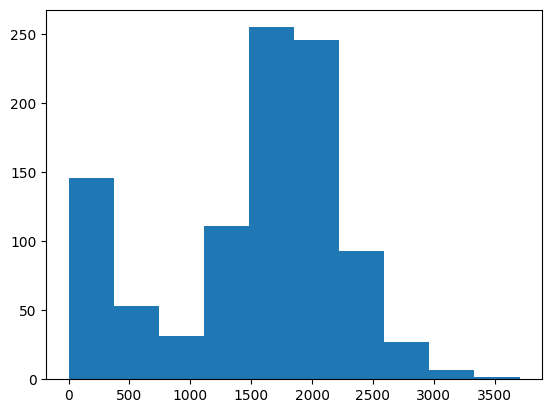

In [11]:
gutenbergdata[0]['text']

'The Project Gutenberg EBook of On the Spanish Main, by John Masefield\n\nThis eBook is for the use of anyone anywhere at no cost and with\nalmost no restrictions whatsoever.  You may copy it, give it away or\nre-use it under the terms of the Project Gutenberg License included\nwith this eBook or online at www.gutenberg.org\n\n\nTitle: On the Spanish Main\n       Or, Some English forays on the Isthmus of Darien.\n\nAuthor: John Masefield\n\nRelease Date: September 28, 2006 [EBook #19396]\n\nLanguage: English\n\nCharacter set encoding: ISO-8859-1\n\n*** START OF THIS PROJECT GUTENBERG EBOOK ON THE SPANISH MAIN ***\n\n\n\n\nProduced by Frank van Drogen, Amy Cunningham and the Online\nDistributed Proofreading Team at http://www.pgdp.net (This\nfile was produced from images generously made available\nby The Internet Archive/Canadian Libraries)\n\n\n\n\n\n\nTRANSCRIBER\'S NOTE:\n\nObvious printing errors were repaired; see the html version for details\nof these changes. Other variation in s

In [9]:
spl = gutenbergdata[0]['text'].split("\n")

In [3]:
gutenbergdata[0]['text'][:1000]

"The Project Gutenberg EBook of On the Spanish Main, by John Masefield\n\nThis eBook is for the use of anyone anywhere at no cost and with\nalmost no restrictions whatsoever.  You may copy it, give it away or\nre-use it under the terms of the Project Gutenberg License included\nwith this eBook or online at www.gutenberg.org\n\n\nTitle: On the Spanish Main\n       Or, Some English forays on the Isthmus of Darien.\n\nAuthor: John Masefield\n\nRelease Date: September 28, 2006 [EBook #19396]\n\nLanguage: English\n\nCharacter set encoding: ISO-8859-1\n\n*** START OF THIS PROJECT GUTENBERG EBOOK ON THE SPANISH MAIN ***\n\n\n\n\nProduced by Frank van Drogen, Amy Cunningham and the Online\nDistributed Proofreading Team at http://www.pgdp.net (This\nfile was produced from images generously made available\nby The Internet Archive/Canadian Libraries)\n\n\n\n\n\n\nTRANSCRIBER'S NOTE:\n\nObvious printing errors were repaired; see the html version for details\nof these changes. Other variation in sp

In [106]:
def citation_data_loop(initdata, searchedalready, interval=100, apikeypath=None):
    allpapers = set()
    filteredinit = [p for p in initdata if p['paperId'] not in searchedalready]
    useids = list( set([f['paperId'] for f in filteredinit]) )
    results = []
    # if os.path.exists(apikeypath):
    #     with open(apikeypath, "r") as f:
    #         apikey = json.load(f)['apikey']
    # else:
    apikey = None
    for i in tqdm(range(0, len(filteredinit), interval)):
        # wait 1 second between requests
        time.sleep(1)
        pids = useids[i:i+interval]
        headers = {}
        if apikey:
            headers['x-api-key'] = apikey
        r = requests.post(
            'https://api.semanticscholar.org/graph/v1/paper/batch',
            params={'fields': 'references.title,references.abstract,title,abstract,tldr,references.year'},
            json={"ids": pids},
            headers=headers
        )
        data = r.json()
        results.extend(data)
        allpapers.update(pids)
    return results, allpapers

# get reference lists for each paper in initdata. Using this, get reference lists for 
def citation_loop_tree(initdata, depth=2, interval=50):
    allpapers = set()
    usedata = initdata
    fulldata = []
    for i in range(depth):
        tmpres, tmpsearched = citation_data_loop(usedata, allpapers, interval)
        nextdata = []
        print(tmpres[0])
        print("Original tmpres length: ", len(tmpres))
        # get rid of all in tmpres with type string
        tmpres = [t for t in tmpres if isinstance(t, dict) and isinstance(t['references'], list)]
        print("New tmpres length: ", len(tmpres))
        for t in tmpres:
            t['depth'] = i
            nextdata.extend(t['references'])
        usedata = nextdata
        fulldata.extend(tmpres)
    return fulldata

for i in range(1, len(fielddata)):
    loopdata = citation_loop_tree(fielddata[i]['data'])
    with open(f"loopdata_{i}.json", "w") as f:
        json.dump(loopdata, f, indent=4)
    # tmpres, tmpsearched = loopdata

100%|██████████| 3/3 [00:19<00:00,  6.35s/it]


{'paperId': '4b0d63a372b3bedf40aa9c6e5ec172ec126be156', 'title': 'Pol II phosphorylation regulates a switch between transcriptional and splicing condensates', 'openAccessPdf': {'url': 'https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6706314', 'status': 'GREEN', 'license': None, 'disclaimer': 'Notice: Paper or abstract available at https://pmc.ncbi.nlm.nih.gov/articles/PMC6706314, which is subject to the license by the author or copyright owner provided with this content. Please go to the source to verify the license and copyright information for your use.'}, 'tldr': {'model': 'tldr@v2.0.0', 'text': 'It is found that the hypophosphorylated C-terminal domain of Pol II is incorporated into mediator condensates and that phosphorylation by regulatory cyclin-dependent kinases reduces this incorporation, and that the hyperphosphorylation C-Terminal domain is preferentially incorporated into condensate that are formed by splicing factors.'}, 'authors': [{'authorId': '49813841', 'name': 'Y. Guo'},

100%|██████████| 118/118 [08:50<00:00,  4.50s/it]


{'paperId': '1e5cc653127eeb348f42208ae751cc458f9bde23', 'title': 'Supplementary Information', 'openAccessPdf': {'url': 'https://doi.org/10.14440/jbm.2018.259.s1024', 'status': 'BRONZE', 'license': None, 'disclaimer': "Notice: The following paper fields have been elided by the publisher: {'references'}. Paper or abstract available at https://api.unpaywall.org/v2/10.14440/jbm.2018.259.s1024?email=<INSERT_YOUR_EMAIL> or https://doi.org/10.14440/jbm.2018.259.s1024, which is subject to the license by the author or copyright owner provided with this content. Please go to the source to verify the license and copyright information for your use."}, 'tldr': None, 'authors': [{'authorId': '2144335598', 'name': 'Haiyan Liu'}, {'authorId': '2115502759', 'name': 'Lin Ma'}, {'authorId': '15930388', 'name': 'Shenghao Xu'}, {'authorId': '40629251', 'name': 'Wenhao Hua'}, {'authorId': '2229453483', 'name': 'Ouyang Jin'}], 'abstract': 'ARPES spectrometers record the photoelectron intensity in an angular 

100%|██████████| 3/3 [00:13<00:00,  4.57s/it]


{'paperId': '88319a9196cc61ff7a75f526c7f9d4ede5a81a68', 'title': 'Spin-polarized oxygen evolution reaction under magnetic field', 'openAccessPdf': {'url': 'https://www.nature.com/articles/s41467-021-22865-y.pdf', 'status': 'GOLD', 'license': 'CCBY', 'disclaimer': 'Notice: Paper or abstract available at https://pmc.ncbi.nlm.nih.gov/articles/PMC8110536, which is subject to the license by the author or copyright owner provided with this content. Please go to the source to verify the license and copyright information for your use.'}, 'tldr': {'model': 'tldr@v2.0.0', 'text': 'It is reported that by using ferromagnetic ordered catalysts as the spin polarizer for spin selection under a constant magnetic field, the OER can be enhanced, however, it does not applicable to non-ferromagnetic catalysts.'}, 'authors': [{'authorId': '2087287308', 'name': 'Xiao Ren'}, {'authorId': '2112665351', 'name': 'Tianze Wu'}, {'authorId': '13361760', 'name': 'Yuanmiao Sun'}, {'authorId': '2152888074', 'name': '

100%|██████████| 117/117 [09:57<00:00,  5.11s/it]


{'paperId': '1e5cc653127eeb348f42208ae751cc458f9bde23', 'title': 'Supplementary Information', 'openAccessPdf': {'url': 'https://doi.org/10.14440/jbm.2018.259.s1024', 'status': 'BRONZE', 'license': None, 'disclaimer': "Notice: The following paper fields have been elided by the publisher: {'references'}. Paper or abstract available at https://api.unpaywall.org/v2/10.14440/jbm.2018.259.s1024?email=<INSERT_YOUR_EMAIL> or https://doi.org/10.14440/jbm.2018.259.s1024, which is subject to the license by the author or copyright owner provided with this content. Please go to the source to verify the license and copyright information for your use."}, 'tldr': None, 'authors': [{'authorId': '2144335598', 'name': 'Haiyan Liu'}, {'authorId': '2115502759', 'name': 'Lin Ma'}, {'authorId': '15930388', 'name': 'Shenghao Xu'}, {'authorId': '40629251', 'name': 'Wenhao Hua'}, {'authorId': '2229453483', 'name': 'Ouyang Jin'}], 'abstract': 'ARPES spectrometers record the photoelectron intensity in an angular 

100%|██████████| 3/3 [00:22<00:00,  7.45s/it]


{'paperId': '88319a9196cc61ff7a75f526c7f9d4ede5a81a68', 'title': 'Spin-polarized oxygen evolution reaction under magnetic field', 'openAccessPdf': {'url': 'https://www.nature.com/articles/s41467-021-22865-y.pdf', 'status': 'GOLD', 'license': 'CCBY', 'disclaimer': 'Notice: Paper or abstract available at https://pmc.ncbi.nlm.nih.gov/articles/PMC8110536, which is subject to the license by the author or copyright owner provided with this content. Please go to the source to verify the license and copyright information for your use.'}, 'tldr': {'model': 'tldr@v2.0.0', 'text': 'It is reported that by using ferromagnetic ordered catalysts as the spin polarizer for spin selection under a constant magnetic field, the OER can be enhanced, however, it does not applicable to non-ferromagnetic catalysts.'}, 'authors': [{'authorId': '2087287308', 'name': 'Xiao Ren'}, {'authorId': '2112665351', 'name': 'Tianze Wu'}, {'authorId': '13361760', 'name': 'Yuanmiao Sun'}, {'authorId': '2152888074', 'name': '

100%|██████████| 221/221 [14:40<00:00,  3.99s/it]


{'paperId': 'f29135743d955db71e867c96cd922ba1f6c072d7', 'title': 'EVIDENCE FOR WARPED DISKS OF YOUNG STARS IN THE GALACTIC CENTER', 'openAccessPdf': {'url': 'https://ui.adsabs.harvard.edu/link_gateway/2009ApJ...697.1741B/PUB_PDF', 'status': 'GREEN', 'license': None, 'disclaimer': 'Notice: Paper or abstract available at https://arxiv.org/abs/0811.3903, which is subject to the license by the author or copyright owner provided with this content. Please go to the source to verify the license and copyright information for your use.'}, 'tldr': {'model': 'tldr@v2.0.0', 'text': 'It is shown that half of the W-R/O stars are compatible with being members of a clockwise rotating system, which is compatible with a coherent structure such as stellar filaments, streams, small clusters or possibly a disk in a dissolving state.'}, 'authors': [{'authorId': '5724878', 'name': 'H. Bartko'}, {'authorId': '2088093', 'name': 'F. Martins'}, {'authorId': '46937848', 'name': 'T. Fritz'}, {'authorId': '11509763

100%|██████████| 2/2 [00:08<00:00,  4.07s/it]


{'paperId': 'be0ea801ccccecbc09db6882ffd2aa0aef7d8870', 'title': 'Civil Wars Kill and Maim People—Long After the Shooting Stops', 'openAccessPdf': {'url': 'http://saramitchell.org/ghobarahhuthrussett.pdf', 'status': 'GREEN', 'license': None, 'disclaimer': "Notice: The following paper fields have been elided by the publisher: {'references', 'abstract'}. Paper or abstract available at https://api.unpaywall.org/v2/10.1017/S0003055403000613?email=<INSERT_YOUR_EMAIL> or https://doi.org/10.1017/S0003055403000613, which is subject to the license by the author or copyright owner provided with this content. Please go to the source to verify the license and copyright information for your use."}, 'tldr': None, 'authors': [{'authorId': '6684318', 'name': 'Hazem Adam Ghobarah'}, {'authorId': '107719445', 'name': 'Paul K. Huth'}, {'authorId': '47394142', 'name': 'B. Russett'}], 'abstract': None, 'references': None}
Original tmpres length:  82
New tmpres length:  9


100%|██████████| 12/12 [00:38<00:00,  3.19s/it]


{'paperId': '575b844de7c561f50de8057daf96970ed6ab4d77', 'title': 'Accurate sex identification of ancient human remains using DNA shotgun sequencing', 'openAccessPdf': {'url': '', 'status': 'CLOSED', 'license': None, 'disclaimer': "Notice: The following paper fields have been elided by the publisher: {'references', 'abstract'}. Paper or abstract available at https://api.unpaywall.org/v2/10.1016/J.JAS.2013.07.004?email=<INSERT_YOUR_EMAIL> or https://doi.org/10.1016/J.JAS.2013.07.004, which is subject to the license by the author or copyright owner provided with this content. Please go to the source to verify the license and copyright information for your use."}, 'tldr': {'model': 'tldr@v2.0.0', 'text': 'The sex of ancient remains is vital for critically testing hypotheses about social structure in prehistoric societies, but morphological methods are imprecise and prone to errors.'}, 'authors': [{'authorId': '2466099', 'name': 'P. Skoglund'}, {'authorId': '5890282', 'name': 'J. Storå'}, {

100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


{'paperId': 'a1bc1ac75c18198b5462dd980729a109bb4a8aba', 'title': 'Empathy and the Novel', 'openAccessPdf': {'url': '', 'status': 'CLOSED', 'license': None, 'disclaimer': "Notice: The following paper fields have been elided by the publisher: {'references', 'abstract'}. Paper or abstract available at https://api.unpaywall.org/v2/10.5860/choice.45-0700?email=<INSERT_YOUR_EMAIL> or https://doi.org/10.5860/choice.45-0700, which is subject to the license by the author or copyright owner provided with this content. Please go to the source to verify the license and copyright information for your use."}, 'tldr': None, 'authors': [{'authorId': '10295111', 'name': 'Suzanne Keen'}], 'abstract': None, 'references': None}
Original tmpres length:  39
New tmpres length:  7


100%|██████████| 11/11 [00:37<00:00,  3.40s/it]


{'paperId': 'c972a50a51df91a4968edae59c2a477321eb0de3', 'title': 'HoME: a Household Multimodal Environment', 'openAccessPdf': {'url': '', 'status': None, 'license': None, 'disclaimer': 'Notice: Paper or abstract available at https://arxiv.org/abs/1711.11017, which is subject to the license by the author or copyright owner provided with this content. Please go to the source to verify the license and copyright information for your use.'}, 'tldr': {'model': 'tldr@v2.0.0', 'text': 'HoME is an open-source, OpenAI Gym-compatible platform extensible to tasks in reinforcement learning, language grounding, sound-based navigation, robotics, multi-agent learning, and more that better enables artificial agents to learn as humans do: in an interactive, multimodal, and richly contextualized setting.'}, 'authors': [{'authorId': '33622538', 'name': 'Simon Brodeur'}, {'authorId': '3439053', 'name': 'Ethan Perez'}, {'authorId': '12679121', 'name': 'Ankesh Anand'}, {'authorId': '2970150', 'name': 'Floria

100%|██████████| 2/2 [00:10<00:00,  5.15s/it]


{'paperId': '2ea64b7c7617f6cc1768373124ca0243d772a90f', 'title': 'Social Bias Frames: Reasoning about Social and Power Implications of Language', 'openAccessPdf': {'url': 'https://www.aclweb.org/anthology/2020.acl-main.486.pdf', 'status': 'HYBRID', 'license': 'CCBY', 'disclaimer': 'Notice: Paper or abstract available at https://arxiv.org/abs/1911.03891, which is subject to the license by the author or copyright owner provided with this content. Please go to the source to verify the license and copyright information for your use.'}, 'tldr': {'model': 'tldr@v2.0.0', 'text': 'It is found that while state-of-the-art neural models are effective at high-level categorization of whether a given statement projects unwanted social bias, they are not effective at spelling out more detailed explanations in terms of Social Bias Frames.'}, 'authors': [{'authorId': '2729164', 'name': 'Maarten Sap'}, {'authorId': '119902504', 'name': 'Saadia Gabriel'}, {'authorId': '3444092', 'name': 'Lianhui Qin'}, {

100%|██████████| 95/95 [04:46<00:00,  3.02s/it]


{'paperId': '28ad018c39d1578bea84e7cedf94459e3dbe1e70', 'title': 'OK-VQA: A Visual Question Answering Benchmark Requiring External Knowledge', 'openAccessPdf': {'url': 'https://arxiv.org/pdf/1906.00067', 'status': 'GREEN', 'license': None, 'disclaimer': 'Notice: Paper or abstract available at https://arxiv.org/abs/1906.00067, which is subject to the license by the author or copyright owner provided with this content. Please go to the source to verify the license and copyright information for your use.'}, 'tldr': {'model': 'tldr@v2.0.0', 'text': 'This paper addresses the task of knowledge-based visual question answering and provides a benchmark, called OK-VQA, where the image content is not sufficient to answer the questions, encouraging methods that rely on external knowledge resources.'}, 'authors': [{'authorId': '35789996', 'name': 'Kenneth Marino'}, {'authorId': '143887493', 'name': 'Mohammad Rastegari'}, {'authorId': '143787583', 'name': 'Ali Farhadi'}, {'authorId': '3012475', 'nam

100%|██████████| 2/2 [00:07<00:00,  3.59s/it]


{'paperId': '1adcb3aac4a46b634b76aa05d81bccae6a61f07a', 'title': 'Autonomy', 'openAccessPdf': {'url': '', 'status': 'CLOSED', 'license': None, 'disclaimer': "Notice: The following paper fields have been elided by the publisher: {'abstract', 'references'}. Paper or abstract available at https://api.unpaywall.org/v2/10.1145/1198555.1198675?email=<INSERT_YOUR_EMAIL> or https://doi.org/10.1145/1198555.1198675, which is subject to the license by the author or copyright owner provided with this content. Please go to the source to verify the license and copyright information for your use."}, 'tldr': {'model': 'tldr@v2.0.0', 'text': 'A thermostat?'}, 'authors': [{'authorId': '2223622395', 'name': 'D. Thalmann'}], 'abstract': None, 'references': None}
Original tmpres length:  100
New tmpres length:  18


100%|██████████| 31/31 [01:23<00:00,  2.71s/it]


{'paperId': '9175cf53b397f3f11a9851fdffa38234097c6fd5', 'title': 'Life as Surplus: Biotechnology and Capitalism in the Neoliberal Era', 'openAccessPdf': {'url': '', 'status': 'CLOSED', 'license': None, 'disclaimer': "Notice: The following paper fields have been elided by the publisher: {'references', 'abstract'}. Paper or abstract available at https://api.unpaywall.org/v2/10.5860/choice.45-6120?email=<INSERT_YOUR_EMAIL> or https://doi.org/10.5860/choice.45-6120, which is subject to the license by the author or copyright owner provided with this content. Please go to the source to verify the license and copyright information for your use."}, 'tldr': {'model': 'tldr@v2.0.0', 'text': 'Life Beyond the Limits: Inventing the Bioeconomy and The Unborn Born Again: Neo-Imperialism, the Evangelical Right, and the Culture of Life is published.'}, 'authors': [{'authorId': '7612938', 'name': 'M. Cooper'}], 'abstract': None, 'references': None}
Original tmpres length:  1254
New tmpres length:  261


100%|██████████| 3/3 [00:13<00:00,  4.43s/it]


{'paperId': 'd37385ffa9fff1625afeb6dc6fc392106aca22ec', 'title': 'Ranking the effectiveness of worldwide COVID-19 government interventions', 'openAccessPdf': {'url': 'https://www.nature.com/articles/s41562-020-01009-0.pdf', 'status': 'GREEN', 'license': 'other-oa', 'disclaimer': "Notice: The following paper fields have been elided by the publisher: {'abstract', 'references'}. Paper or abstract available at https://api.unpaywall.org/v2/10.1038/s41562-020-01009-0?email=<INSERT_YOUR_EMAIL> or https://doi.org/10.1038/s41562-020-01009-0, which is subject to the license by the author or copyright owner provided with this content. Please go to the source to verify the license and copyright information for your use."}, 'tldr': {'model': 'tldr@v2.0.0', 'text': 'It is found that combinations of softer measures, such as risk communication or those increasing healthcare capacity, can be almost as effective as disruptive lockdowns.'}, 'authors': [{'authorId': '2160037389', 'name': 'Nina Haug'}, {'a

100%|██████████| 51/51 [03:19<00:00,  3.92s/it]


{'paperId': 'c0cd3d1ff165807ef4b755ed2e5cf1e0e4632b18', 'title': 'The Business Model: Recent Developments and Future Research', 'openAccessPdf': {'url': '', 'status': 'CLOSED', 'license': None, 'disclaimer': "Notice: The following paper fields have been elided by the publisher: {'abstract', 'references'}. Paper or abstract available at https://api.unpaywall.org/v2/10.1177/0149206311406265?email=<INSERT_YOUR_EMAIL> or https://doi.org/10.1177/0149206311406265, which is subject to the license by the author or copyright owner provided with this content. Please go to the source to verify the license and copyright information for your use."}, 'tldr': None, 'authors': [{'authorId': '3376539', 'name': 'C. Zott'}, {'authorId': '143830157', 'name': 'R. Amit'}, {'authorId': '101415693', 'name': 'Lorenzo Massa'}], 'abstract': None, 'references': None}
Original tmpres length:  2117
New tmpres length:  442


100%|██████████| 3/3 [00:15<00:00,  5.21s/it]


{'paperId': 'ed98428400677e85a4db9bf54a5e830228160333', 'title': 'Gender differences in couples’ division of childcare, work and mental health during COVID-19', 'openAccessPdf': {'url': 'https://link.springer.com/content/pdf/10.1007/s11150-020-09534-7.pdf', 'status': 'GREEN', 'license': 'other-oa', 'disclaimer': 'Notice: Paper or abstract available at https://pmc.ncbi.nlm.nih.gov/articles/PMC7811157, which is subject to the license by the author or copyright owner provided with this content. Please go to the source to verify the license and copyright information for your use.'}, 'tldr': None, 'authors': [{'authorId': '152161043', 'name': 'Gema Zamarro'}, {'authorId': '103885846', 'name': 'M. Prados'}], 'abstract': 'The current COVID-19 crisis, with its associated school and daycare closures as well as social-distancing requirements, has the potential to magnify gender differences both in terms of childcare arrangements within the household and at work. We use data from a nationally rep

100%|██████████| 84/84 [05:07<00:00,  3.66s/it]


{'paperId': '2d16f050897c4ba31e8f225a5d246a508b04a352', 'title': 'The Tennessee study of class size in the early school grades.', 'openAccessPdf': {'url': '', 'status': 'CLOSED', 'license': None, 'disclaimer': "Notice: The following paper fields have been elided by the publisher: {'abstract', 'references'}. Paper or abstract available at https://api.unpaywall.org/v2/10.2307/1602360?email=<INSERT_YOUR_EMAIL> or https://doi.org/10.2307/1602360, which is subject to the license by the author or copyright owner provided with this content. Please go to the source to verify the license and copyright information for your use."}, 'tldr': {'model': 'tldr@v2.0.0', 'text': 'The Tennessee class size project is a three-phase study designed to determine the effect of smaller class size in the earliest grades on short-term and long-term pupil performance and it was clear that smaller classes did produce substantial improvement in early learning and cognitive studies.'}, 'authors': [{'authorId': '47976

In [ ]:
fielddata[1]['data']

{'paperId': '006e91a9c37de2821800373949b1eb0859b3faab',
 'externalIds': {'PubMedCentral': '7343608',
  'MAG': '2955850137',
  'DOI': '10.1038/s41588-020-0631-4',
  'CorpusId': 198266898,
  'PubMed': '32451458'},
 'title': 'Mendelian randomization accounting for correlated and uncorrelated pleiotropic effects using genome-wide summary statistics',
 'year': 2019,
 'referenceCount': 73,
 'citationCount': 452,
 'fieldsOfStudy': ['Biology', 'Medicine'],
 'authors': [{'authorId': '32099533', 'name': 'J. Morrison'},
  {'authorId': '2599776', 'name': 'Nicholas W. Knoblauch'},
  {'authorId': '35856957', 'name': 'Joseph H. Marcus'},
  {'authorId': '145761702', 'name': 'M. Stephens'},
  {'authorId': '2157519374', 'name': 'Xin He'}]}

In [84]:
loopdata

[]

In [103]:
# save loopdata to json
with open("loopdata_0.json", "w") as f:
    json.dump(loopdata, f, indent=4)

In [79]:
len(loopdata)

2374

In [100]:
r = requests.post(
    'https://api.semanticscholar.org/graph/v1/paper/batch',
    params={'fields': 'references.title,references.abstract,title,abstract,tldr,references.year'},
    json={"ids": ["0d08ffccc982781e310bb184397bbe64b9aef157", "0e0e706e13f160e74cac9556f28ab9a358c148d2"]},
    # headers={'x-api-key': 'kkm4wuxwU28VYd7E7lywP7xsJytTaIpn5pdR08K0'}
)
data = r.json()